## 1.取得セクション

In [120]:
# APIの基本設定
API_TOKEN = "YOUR_API_TOKEN"  # 実際のAPIトークンに置き換えてください
API_TOKEN = "Hgt7Gj3Il3rQovE8OiU817jgmrKe9jnM"  # テスト後に削除
BASE_URL = "https://info.gbiz.go.jp/hojin"
HEADERS = {"X-hojinInfo-api-token": API_TOKEN}

# APIリクエストの間隔（秒）- レート制限対策
REQUEST_INTERVAL = 0.5

print("API設定が完了しました")
print(f"Base URL: {BASE_URL}")

API設定が完了しました
Base URL: https://info.gbiz.go.jp/hojin


##### データ取得テスト

In [122]:
from pprint import pprint
import requests

def get_subsidy_data_test():
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': '20200401',
        'to': '20210331',
        'page': '1'
    }
    
    response = requests.get(endpoint, headers=HEADERS, params=params)
    return response.json()

test_data = get_subsidy_data_test() 
pprint(test_data)


{'errors': None,
 'hojin-infos': [{'corporate_number': '1000020470007',
                  'kana': 'おきなわけん',
                  'location': '沖縄県那覇市泉崎１丁目２－２',
                  'name': '沖縄県',
                  'name_en': 'Okinawa Prefectural Government',
                  'postal_code': '9000021',
                  'status': '-',
                  'subsidy': [{'amount': '6397000',
                               'date_of_approval': '2020-07-08',
                               'government_departments': '防衛省',
                               'joint_signatures': None,
                               'note': None,
                               'subsidy_resource': None,
                               'target': None,
                               'title': '美咲特別支援学校防音事業（実施設計）'},
                              {'amount': '2578000',
                               'date_of_approval': '2020-06-04',
                               'government_departments': '防衛省',
                               'joint_si

全件取得前にデータ件数の調査

In [123]:
def get_subsidy_data_count():
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': '20200401',
        'to': '20210331'
    }
    response = requests.get(endpoint, headers=HEADERS, params=params)
    data = response.json()
    return data['totalCount']

subsidy_count = get_subsidy_data_count()
print(f"2020年度の補助金情報の総件数: {subsidy_count}件")

2020年度の補助金情報の総件数: 91892件


### データ取得

In [125]:
import sqlite3
import aiohttp
import asyncio
import time

def setup_database(db_connect):
    db_cursor = db_connect.cursor()
    
    # 補助金テーブル
    db_cursor.execute('''
    CREATE TABLE IF NOT EXISTS subsidies (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        corporate_number TEXT,
        company_name TEXT,
        subsidy_date TEXT,
        subsidy_title TEXT,
        amount TEXT
    )
    ''')
    
    # 処理済みページ記録テーブル
    db_cursor.execute('''
    CREATE TABLE IF NOT EXISTS processed_pages (
        data_type TEXT,
        page_number INTEGER,
        fiscal_year INTEGER,
        PRIMARY KEY (data_type, page_number, fiscal_year)
    )
    ''')
    
    db_connect.commit()
    return db_connect

def save_data_to_db(db_connect, data, fiscal_year):
    if not data or "hojin-infos" not in data:
        return 0, 0
    
    db_cursor = db_connect.cursor()
    companies_count = 0
    subsidies_count = 0
    
    for company in data["hojin-infos"]:
        companies_count += 1
        
        if "subsidy" in company and company["subsidy"]:
            for subsidy in company["subsidy"]:
                db_cursor.execute('''
                INSERT INTO subsidies 
                (corporate_number, company_name, subsidy_date, subsidy_title, amount)
                VALUES (?, ?, ?, ?, ?)
                ''', (
                    company.get("corporate_number", ""),
                    company.get("name", ""),
                    subsidy.get("date_of_approval", ""),
                    subsidy.get("title", ""),
                    subsidy.get("amount", "")
                ))
                subsidies_count += 1
    
    db_connect.commit()
    return companies_count, subsidies_count

async def fetch_subsidy_data(session, from_date=None, to_date=None, page=1):
    """非同期APIリクエスト - 補助金情報取得"""
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': from_date,
        'to': to_date,
        'page': str(page)
    }
    
    try:
        async with session.get(endpoint, headers=HEADERS, params=params) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"エラー: HTTPステータスコード {response.status}")
                return None
    except Exception as e:
        print(f"リクエストエラー: {e}")
        return None

def is_page_processed(db_connect, page, fiscal_year):
    """ページが処理済みかチェック"""
    db_cursor = db_connect.cursor()
    db_cursor.execute(
        'SELECT 1 FROM processed_pages WHERE data_type = ? AND page_number = ? AND fiscal_year = ?', 
        ('subsidy', page, fiscal_year)
    )
    return db_cursor.fetchone() is not None

def mark_page_processed(db_connect, page, fiscal_year):
    """ページを処理済みとしてマーク"""
    db_cursor = db_connect.cursor()
    db_cursor.execute(
        'INSERT OR IGNORE INTO processed_pages VALUES (?, ?, ?)', 
        ('subsidy', page, fiscal_year)
    )
    db_connect.commit()

async def get_subsidy_data_prod(from_date, to_date, fiscal_year, db_connect, batch_size=30):
    """非同期実行で全国の補助金情報を取得"""
    
    setup_database(db_connect)
    
    async with aiohttp.ClientSession() as session:
        # 最初に1ページ目を取得して総ページ数を確認
        initial_data = await fetch_subsidy_data(session, from_date, to_date, 1)
        if not initial_data or "totalPage" not in initial_data:
            print("総ページ数の取得に失敗しました")
            return
        
        total_pages = int(initial_data["totalPage"])
        print(f"補助金情報総ページ数: {total_pages}、期間: {from_date}～{to_date}、年度: {fiscal_year}")
        
        # 1ページ目の処理
        if not is_page_processed(db_connect, 1, fiscal_year):
            companies, subsidies = save_data_to_db(db_connect, initial_data, fiscal_year)
            mark_page_processed(db_connect, 1, fiscal_year)
            print(f"ページ 1: {companies}社の情報と{subsidies}件の補助金情報を保存")
        else:
            print("ページ 1は処理済みです")
        
        # 残りのページをbatch_sizeページずつバッチ処理
        total_companies = 0
        total_subsidies = 0
        processed_pages = 1
        start_time = time.time()
        
        for start_page in range(2, total_pages + 1, batch_size):
            batch_tasks = []
            batch_pages = []
            
            for page in range(start_page, min(start_page + batch_size, total_pages + 1)):
                if not is_page_processed(db_connect, page, fiscal_year):
                    batch_tasks.append(fetch_subsidy_data(session, from_date, to_date, page))
                    batch_pages.append(page)
                else:
                    print(f"ページ {page} は処理済みです")
            
            if batch_tasks:
                print(f"バッチ取得: {len(batch_tasks)} ページ")
                results = await asyncio.gather(*batch_tasks)
                
                for i, result in enumerate(results):
                    page = batch_pages[i]
                    if result:
                        companies, subsidies = save_data_to_db(db_connect, result, fiscal_year)
                        mark_page_processed(db_connect, page, fiscal_year)
                        total_companies += companies
                        total_subsidies += subsidies
                        processed_pages += 1
                        
                        # 進捗表示
                        elapsed_time = time.time() - start_time
                        avg_time_per_page = elapsed_time / processed_pages if processed_pages > 0 else 0
                        remaining_pages = total_pages - processed_pages
                        est_remaining_time = avg_time_per_page * remaining_pages
                        
                        print(f"ページ {page}/{total_pages}: {companies}社, {subsidies}件 " +
                              f"(進捗: {processed_pages/total_pages*100:.1f}%, 残り約{est_remaining_time/60:.1f}分)")
                
                await asyncio.sleep(1)  # APIレート制限対策
    
    # 最終結果の表示
    db_cursor = db_connect.cursor()
    
    # companies テーブルは使用していないので修正
    db_cursor.execute("SELECT COUNT(DISTINCT corporate_number) FROM subsidies")
    total_companies = db_cursor.fetchone()[0]
    
    db_cursor.execute("SELECT COUNT(*) FROM subsidies")
    total_subsidies = db_cursor.fetchone()[0]
    
    elapsed_time = time.time() - start_time
    print(f"\n処理完了 ({elapsed_time/60:.1f}分): {fiscal_year}年度データ")
    print(f"データベースには{total_companies}社の法人情報と{total_subsidies}件の補助金情報があります")


In [126]:
# 取得年度を2020年で定義（新型コロナの影響により最もデータが豊富に取れると考えた）
FISCAL_YEAR = 2020
from_date = f"{FISCAL_YEAR}0401"
to_date = f"{FISCAL_YEAR+1}0331"

# ダウンロード時sqlite3に保存
db_connect = sqlite3.connect('gbiz.sqlite3')

データを取得して外部保存
- 補助金の件数が、最初に調べた件数と同じになることを確かめてください
- 違っていれば、再実行してください

In [127]:

await get_subsidy_data_prod(
    from_date=from_date, 
    to_date=to_date, 
    fiscal_year=FISCAL_YEAR, 
    db_connect=db_connect,
    batch_size=40  # バッチサイズを指定
)
db_connect.close()

補助金情報総ページ数: 919、期間: 20200401～20210331、年度: 2020
ページ 1は処理済みです
ページ 2 は処理済みです
ページ 3 は処理済みです
ページ 4 は処理済みです
ページ 5 は処理済みです
ページ 6 は処理済みです
ページ 7 は処理済みです
ページ 8 は処理済みです
ページ 9 は処理済みです
ページ 10 は処理済みです
ページ 11 は処理済みです
ページ 12 は処理済みです
ページ 13 は処理済みです
ページ 14 は処理済みです
ページ 15 は処理済みです
ページ 16 は処理済みです
ページ 17 は処理済みです
ページ 18 は処理済みです
ページ 19 は処理済みです
ページ 20 は処理済みです
ページ 21 は処理済みです
ページ 22 は処理済みです
ページ 23 は処理済みです
ページ 24 は処理済みです
ページ 25 は処理済みです
ページ 26 は処理済みです
ページ 27 は処理済みです
ページ 28 は処理済みです
ページ 29 は処理済みです
ページ 30 は処理済みです
ページ 31 は処理済みです
ページ 32 は処理済みです
ページ 33 は処理済みです
ページ 34 は処理済みです
ページ 35 は処理済みです
ページ 36 は処理済みです
ページ 37 は処理済みです
ページ 38 は処理済みです
ページ 39 は処理済みです
ページ 40 は処理済みです
ページ 41 は処理済みです
ページ 42 は処理済みです
ページ 43 は処理済みです
ページ 44 は処理済みです
ページ 45 は処理済みです
ページ 46 は処理済みです
ページ 47 は処理済みです
ページ 48 は処理済みです
ページ 49 は処理済みです
ページ 50 は処理済みです
ページ 51 は処理済みです
ページ 52 は処理済みです
ページ 53 は処理済みです
ページ 54 は処理済みです
ページ 55 は処理済みです
ページ 56 は処理済みです
ページ 57 は処理済みです
ページ 58 は処理済みです
ページ 59 は処理済みです
ページ 60 は処理済みです
ページ 61 は処理済みです
ページ 62 は処理済みです
ページ 63 は処理済みです
ページ 64 は処理済みです
ページ

## 2.分析セクション


メモリ上にデータを取り込む

In [128]:
import sqlite3
import pandas as pd

db_connect = sqlite3.connect('gbiz.sqlite3')

subsidy_df = pd.read_sql_query("SELECT * FROM subsidies",db_connect)


### データの構造をチェック

In [129]:
# 補助金交付データ状況チェック
subsidy_df.columns

Index(['id', 'corporate_number', 'company_name', 'subsidy_date',
       'subsidy_title', 'amount'],
      dtype='object')

In [ ]:
# 補助金交付が企業に対して重複しているかを一応チェック
subsidy_df = subsidy_df.sort_values('corporate_number', ascending=False)

In [139]:
subsidy_df.tail(30)

,id,corporate_number,company_name,subsidy_date,subsidy_title,amount
21202,21203,1000020014532,東神楽町,2020-09-16,都市構造再編集中支援事業,3000000
75500,75501,1000020014532,東神楽町,2017-09-21,学校を核とした地域力強化プラン,851000
13600,13601,1000020014524,鷹栖町,2019-11-29,循環型社会形成推進交付金,264000
28600,28601,1000020014524,鷹栖町,2020-08-12,文化施設の感染症防止対策事業,10249000
21201,21202,1000020014524,鷹栖町,2020-09-16,都市構造再編集中支援事業,5700000
11501,11502,1000020014524,鷹栖町,2020-08-20,循環型社会形成推進交付金,499000
71500,71501,1000020014524,鷹栖町,2018-09-13,学校を核とした地域力強化プラン,127000
21200,21201,1000020014061,古平町,2020-09-16,都市構造再編集中支援事業,225200000
41500,41501,1000020013641,乙部町,2019-05-17,農山漁村振興交付金,10000000
11500,11501,1000020013641,乙部町,2020-08-20,循環型社会形成推進交付金,373000


### [重要]API構造の欠陥の指摘と調査

データを眺めた時に、交付日データの中に2020年度のものではないものが含まれていた。

このことは、最初に期間を2020年度の抽出したことと矛盾しており、APIの欠陥である。また、本調査において、データの信頼性が失われているという前提から、対応が必要になる。

そのため今回は、現状得られたデータの取得年度に着目し再度出発を試みる。

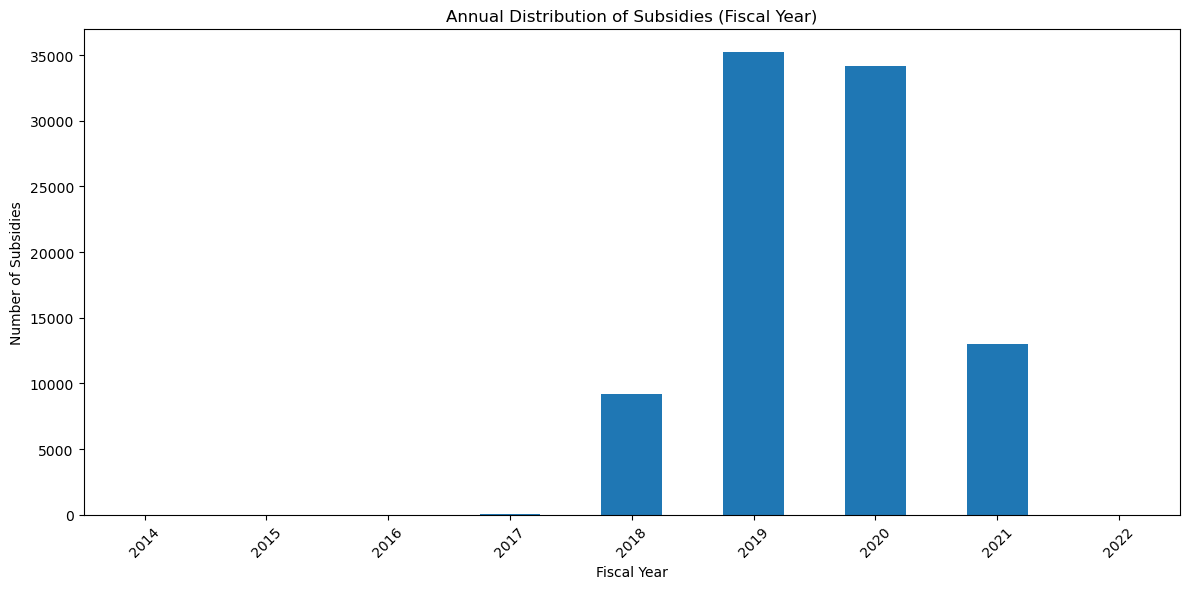

年別分布:
subsidy_date
2014        1
2015        3
2016        6
2017       24
2018     9164
2019    35209
2020    34162
2021    13012
2022        4
Name: count, dtype: int64


In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def is_in_fiscal_year(date_str, fiscal_year):
    """
    指定した会計年度に日付が含まれるかを判定
    
    Args:
        date_str (str): 日付文字列 (YYYY-MM-DD形式)
        fiscal_year (int): 会計年度
    
    Returns:
        bool: 指定した会計年度に含まれるか
    """
    if pd.isna(date_str) or date_str == '':
        return False
    
    try:
        date = datetime.strptime(str(date_str), "%Y-%m-%d")
        fiscal_start = datetime(fiscal_year, 4, 1)
        fiscal_end = datetime(fiscal_year + 1, 3, 31)
        
        return fiscal_start <= date <= fiscal_end
    except ValueError:
        return False

def visualize_fiscal_year_distribution(df):
    # 各補助金の会計年度を計算
    def get_fiscal_year(date_str):
        if pd.isna(date_str) or date_str == '':
            return None
        try:
            date = datetime.strptime(str(date_str), "%Y-%m-%d")
            return date.year if date.month < 4 else date.year + 1
        except ValueError:
            return None
    
    # 会計年度を抽出
    fiscal_years = df['subsidy_date'].dropna().apply(get_fiscal_year)
    
    # 会計年度別の分布を計算
    fiscal_year_counts = fiscal_years.value_counts().sort_index()
    
    # 棒グラフで可視化
    plt.figure(figsize=(12, 6))
    fiscal_year_counts.plot(kind='bar')
    plt.title('Annual Distribution of Subsidies (Fiscal Year)')
    plt.xlabel('Fiscal Year')
    plt.ylabel('Number of Subsidies')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # テキストでの詳細出力
    print("年別分布:")
    print(fiscal_year_counts)
    
    return fiscal_year_counts

# 実行
fiscal_year_distribution = visualize_fiscal_year_distribution(subsidy_df)

In [163]:
def get_fiscal_year(date_str):
    if pd.isna(date_str) or date_str == '':
        return None
    try:
        date = datetime.strptime(str(date_str), "%Y-%m-%d")
        return date.year if date.month < 4 else date.year + 1
    except ValueError:
        return None

# 2020年度のデータを抽出
subsidy_2020_df = subsidy_df[subsidy_df['subsidy_date'].apply(get_fiscal_year) == 2020]

print("2020年度の補助金データ:")
print(f"総件数: {len(subsidy_2020_df)}")

2020年度の補助金データ:
総件数: 34162


In [169]:
subsidy_2020_df[subsidy_2020_df["corporate_number"].isin(["イニシア"])]

,id,corporate_number,company_name,subsidy_date,subsidy_title,amount


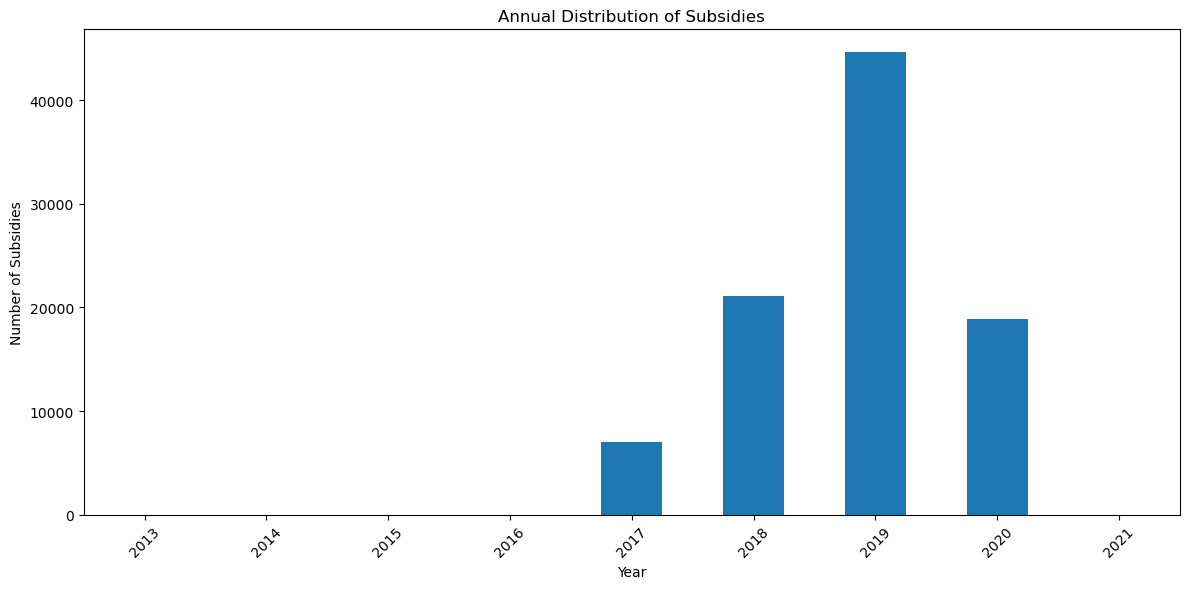

年別分布:
subsidy_date
2013        1
2014        2
2015        5
2016       10
2017     6977
2018    21125
2019    44613
2020    18845
2021        7
Name: count, dtype: int64


In [160]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_year_distribution(df):
    # Noneや不正な値を除外して年を抽出
    years = df['subsidy_date'].dropna().apply(lambda x: str(x)[:4] if isinstance(x, str) else None)
    
    # 年別の分布を計算
    year_counts = years.value_counts().sort_index()
    
    # 棒グラフで可視化
    plt.figure(figsize=(12, 6))
    year_counts.plot(kind='bar')
    plt.title('Annual Distribution of Subsidies')
    plt.xlabel('Year')
    plt.ylabel('Number of Subsidies')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # テキストでの詳細出力
    print("年別分布:")
    print(year_counts)
    
    return year_counts

# 実行
year_distribution = visualize_year_distribution(subsidy_df)

2019年度（会計年度）の補助金データ:
総件数: 34162
総額: 6,026,156,065,470.0円
平均額: 183,478,141円
中央値: 3,640,000円

補助金タイトルTOP10:
subsidy_title
国宝重要文化財文化財等保存整備事業                          3129
電力需要の低減に資する設備投資支援事業費補助金                    2223
農業経営安定事業収入減少影響緩和対策交付金                      1821
畑作物の直接支払交付金                                1789
農業経営安定事業生産条件不利補正対策交付金                      1436
河川等災害復旧事業                                  1213
営農継続支払                                     1169
循環型社会形成推進交付金                                754
省エネルギー投資促進に向けた支援補助金（エネルギー使用合理化等事業者支援事業）     729
省エネルギー設備投資に係る利子補給金助成事業費補助金                  662
Name: count, dtype: int64


/usr/local/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/core/pyl

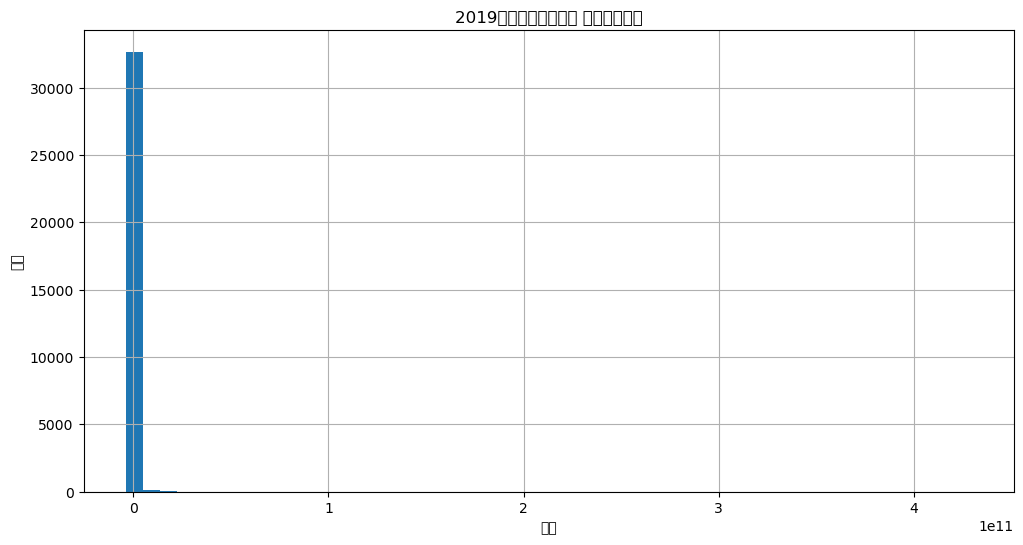

In [154]:
import pandas as pd
from datetime import datetime

# 文字列の'amount'カラムを数値に変換
subsidy_df['amount'] = pd.to_numeric(subsidy_df['amount'], errors='coerce')

def is_fiscal_year(date_str, fiscal_year=2019):
    """
    指定した会計年度に日付が含まれるかを判定
    
    Args:
        date_str (str): 日付文字列 (YYYY-MM-DD形式)
        fiscal_year (int): 会計年度（デフォルト2019年度）
    
    Returns:
        bool: 指定した会計年度に含まれるか
    """
    # Noneや空白値をチェック
    if pd.isna(date_str) or date_str == '':
        return False
    
    try:
        date = datetime.strptime(str(date_str), "%Y-%m-%d")
        fiscal_start = datetime(fiscal_year, 4, 1)
        fiscal_end = datetime(fiscal_year + 1, 3, 31)
        
        return fiscal_start <= date <= fiscal_end
    except ValueError:
        return False

# 2019年度のデータを抽出
df_2019_fiscal_year = subsidy_df[subsidy_df['subsidy_date'].apply(lambda x: is_fiscal_year(x))]

print("2019年度（会計年度）の補助金データ:")
print(f"総件数: {len(df_2019_fiscal_year)}")
print(f"総額: {df_2019_fiscal_year['amount'].sum():,}円")
print(f"平均額: {df_2019_fiscal_year['amount'].mean():,.0f}円")
print(f"中央値: {df_2019_fiscal_year['amount'].median():,.0f}円")

# 補助金タイトルのトップ10
print("\n補助金タイトルTOP10:")
print(df_2019_fiscal_year['subsidy_title'].value_counts().head(10))

# 金額分布
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_2019_fiscal_year['amount'].hist(bins=50)
plt.title('2019年度（会計年度） 補助金額分布')
plt.xlabel('金額')
plt.ylabel('頻度')
plt.show()

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 補助金タイトル別の件数分析
def analyze_subsidy_title_counts(df_2019_fiscal_year):
    # 補助金タイトル別の件数を計算
    title_counts = df_2019_fiscal_year['subsidy_title'].value_counts()
    
    # 上位30件を表示
    print("2019年度 補助金タイトル別 件数 TOP30:")
    print(title_counts.head(30))
    
    # 件数の多いトップ30のタイトルでグラフ作成
    plt.figure(figsize=(15, 8))
    title_counts.plot(kind='bar')
    plt.title('2019年度 補助金タイトル別 件数 TOP30')
    plt.xlabel('補助金タイトル')
    plt.ylabel('件数')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    return title_counts

# 実行
subsidy_counts = analyze_subsidy_title_counts(df_2019_fiscal_year)

2019年度 補助金タイトル別 件数 TOP30:
subsidy_title
国宝重要文化財文化財等保存整備事業                                                 3129
電力需要の低減に資する設備投資支援事業費補助金                                           2223
農業経営安定事業収入減少影響緩和対策交付金                                             1821
畑作物の直接支払交付金                                                       1789
農業経営安定事業生産条件不利補正対策交付金                                             1436
河川等災害復旧事業                                                         1213
営農継続支払                                                            1169
循環型社会形成推進交付金                                                       754
省エネルギー投資促進に向けた支援補助金（エネルギー使用合理化等事業者支援事業）                            729
省エネルギー設備投資に係る利子補給金助成事業費補助金                                         662
省エネルギー投資促進に向けた支援補助金（省エネルギー投資促進に向けた支援補助事業のうちエネルギー使用合理化等事業者支援事業）     426
私立高等学校等ＩＣＴ教育設備整備推進事業費                                              364
畑作物の直接支払交付金（営農継続支払）                                                340
畑作の直接支払交付金                           

/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_52299/428815737.py:21: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_52299/428815737.py:21: UserWarning: Glyph 23453 (\N{CJK UNIFIED IDEOGRAPH-5B9D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_52299/428815737.py:21: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_52299/428815737.py:21: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_52299/428815737.py:21: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3

KeyboardInterrupt: 

In [143]:
fiscal_2020_subsidies.head()

,id,corporate_number,company_name,subsidy_date,subsidy_title,amount
28799,28800,9700150053545,萩まちじゅう博物館文化遺産活用事業実行委員会,2020-08-06,地域文化財総合活用推進事業（地域文化遺産）,6592000
1598,1599,9700150003112,エヌ・ティ・ティ企業年金基金,2020-04-01,国家公務員共済組合連合会等助成,217433000
1599,1600,9700150003112,エヌ・ティ・ティ企業年金基金,2020-04-01,国家公務員共済組合連合会等助成,45150000
1898,1899,9700150000613,警察共済組合,2020-09-07,令和２年度警察共済組合特定健康診査・保健指導補助金,5146000
1897,1898,9700150000613,警察共済組合,2020-04-01,令和２年度国家公務員共済組合負担金,15290180000


In [144]:
non_fiscal_2020_subsidies.head()

,id,corporate_number,company_name,subsidy_date,subsidy_title,amount
65799,65800,9700150066811,干立公民館,2019-04-01,国宝重要文化財文化財等保存整備事業,1384000
76899,76900,9700150053545,萩まちじゅう博物館文化遺産活用事業実行委員会,2017-04-03,文化遺産総合活用活性化事業（地域文化遺産活性化事業）,3524000
67799,67800,9700150053545,萩まちじゅう博物館文化遺産活用事業実行委員会,2019-04-01,地域文化財総合活用推進事業（地域文化遺産）,6234000
91499,91500,9700150052200,尾道市歴史文化まちづくり推進協議会,2017-04-03,日本遺産魅力発信推進事業,10000000
28499,28500,9700150051994,北広島町農山村体験推進協議会,2019-09-09,農山漁村振興交付金,2000000


補助金データに関して、企業IDで集約

In [6]:
company_counts_df = subsidy_df.groupby('corporate_number').agg({
    'id': 'count',  # 補助金の数をカウント
}).reset_index().rename(columns={'id': 'subsidy_count'})

In [82]:
company_counts_df.columns

Index(['corporate_number', 'subsidy_count'], dtype='object')

In [83]:
company_counts_df.shape

(97550, 2)

In [110]:
# 降順でソート
company_counts_df = company_counts_df.sort_values('subsidy_count', ascending=False)
company_counts_df.head()

,corporate_number,subsidy_count
76314,8000020460001,1047
11264,2000020350001,921
65254,7000020010006,908
65287,7000020070009,882
43751,5000020150002,868


企業の補助金受け取り回数でソートして、グラフで可視化

In [7]:
company_counts_df.head(800).to_csv('company_counts.csv', index=False)

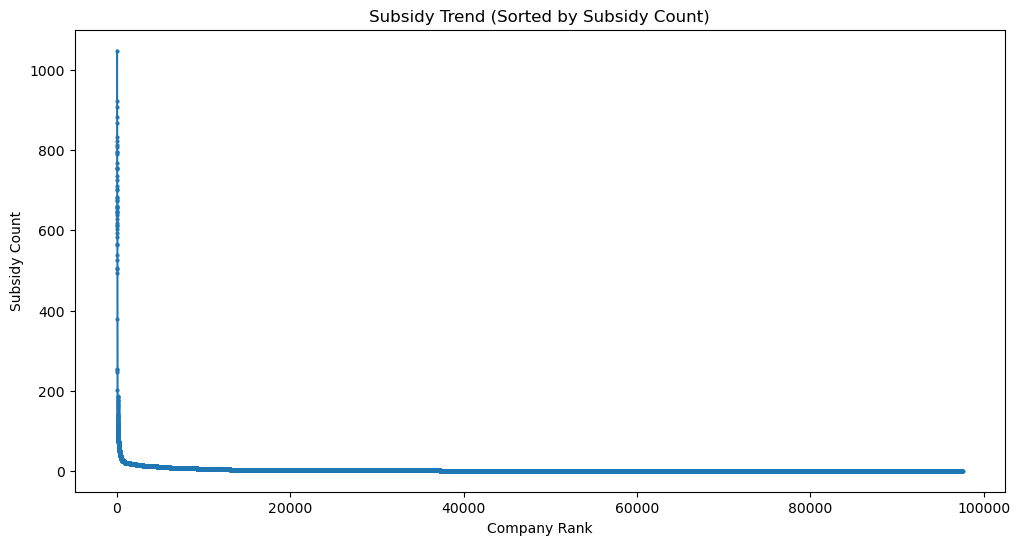

In [111]:
import matplotlib.pyplot as plt


def subsidy_trend_analysis(df, variable):
    sorted_df = df.sort_values(variable, ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sorted_df)), sorted_df[variable], 'o-', markersize=2)
    plt.title('Subsidy Trend (Sorted by Subsidy Count)')
    plt.xlabel('Company Rank')
    plt.ylabel('Subsidy Count')
    plt.show()

subsidy_trend_analysis(df=company_counts_df, variable='subsidy_count')




以上の可視化情報から、以降補助金の受け取り頻度はロングテール（Long Tail） 分布に従うという仮説のもと詳細調査をしていく。

つまり、
- ヘッド：左側（急激に高い値の部分）の超高頻度受給の企業クラスタ
- ロングテイル：右側（長く伸びる低い値の部分）の一般層のクラスタ



In [8]:
def cluster_subsidies_by_rank(df, top_n=500):
    """
    企業の補助金受給数を順位で分類し、上位N社を高頻度グループとする
    
    引数:
    df: 'corporate_number'と'subsidy_count'カラムを持つDataFrame
    top_n: 高頻度グループとする上位企業数 (デフォルト: 500)
    
    戻り値:
    tuple: (high_frequency_group_df, low_frequency_group_df)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # 元のデータフレームを変更しないようにコピー
    df_copy = df.copy()
    
    # 補助金数で降順ソート
    df_sorted = df_copy.sort_values('subsidy_count', ascending=False).reset_index(drop=True)
    
    # 上位N社を高頻度グループとして抽出
    high_frequency_group_df = df_sorted.iloc[:top_n]
    low_frequency_group_df = df_sorted.iloc[top_n:]
    
    # 閾値（N+1位の補助金数）
    threshold = low_frequency_group_df['subsidy_count'].iloc[0] if len(low_frequency_group_df) > 0 else 0
    
    # 分類結果を表示
    print(f"上位{top_n}社を高頻度グループに分類")
    print(f"閾値: {threshold}回以上の補助金受給")
    print(f"高頻度グループ: {len(high_frequency_group_df)}社")
    print(f"平均補助金数: {high_frequency_group_df['subsidy_count'].mean():.2f}")
    print(f"最大補助金数: {high_frequency_group_df['subsidy_count'].max()}")
    print(f"最小補助金数: {high_frequency_group_df['subsidy_count'].min()}")
    print(f"\n低頻度グループ: {len(low_frequency_group_df)}社")
    print(f"平均補助金数: {low_frequency_group_df['subsidy_count'].mean():.2f}")
    print(f"最大補助金数: {low_frequency_group_df['subsidy_count'].max()}")
    print(f"最小補助金数: {low_frequency_group_df['subsidy_count'].min()}")
    
    # クラスタリング結果を可視化
    plt.figure(figsize=(12, 8))
    
    # 高頻度グループをプロット（赤）
    plt.scatter(range(len(high_frequency_group_df)), 
                high_frequency_group_df['subsidy_count'],
                c='red',
                label=f'High Frequency Group (Top {top_n} companies)')
    
    # 低頻度グループをプロット（青）
    plt.scatter(range(len(high_frequency_group_df), len(df_sorted)), 
                low_frequency_group_df['subsidy_count'],
                c='blue',
                label=f'Low Frequency Group ({len(low_frequency_group_df)} companies)')
    
    # 閾値ラインを追加（黄色）
    plt.axhline(y=threshold, color='yellow', linestyle='-', linewidth=2,
                label=f'Threshold: {threshold} subsidies')
    
    plt.xlabel('Company Rank')
    plt.ylabel('Subsidy Count')
    plt.title(f'Distribution of Subsidies Among Companies (Top {top_n} Highlighted)')
    plt.legend()
    
    return high_frequency_group_df, low_frequency_group_df

上位492社を高頻度グループに分類
閾値: 31回以上の補助金受給
高頻度グループ: 492社
平均補助金数: 125.47
最大補助金数: 1047
最小補助金数: 31

低頻度グループ: 97058社
平均補助金数: 2.58
最大補助金数: 31
最小補助金数: 1


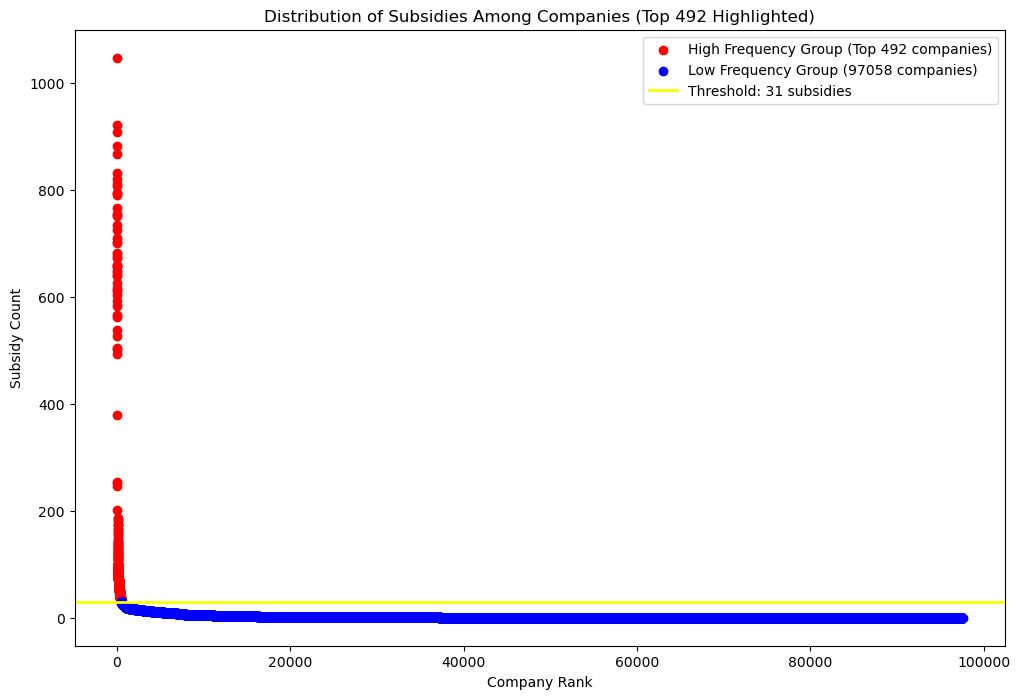

In [11]:
high_frequency_group_df, low_frequency_group_df = cluster_subsidies_by_rank(df=company_counts_df,top_n=492)

### ヘッド解析

In [14]:
high_frequency_group_df.shape

(492, 2)

In [15]:
high_frequency_group_df.columns

Index(['corporate_number', 'subsidy_count'], dtype='object')

In [16]:
company_df.columns

Index(['corporate_number', 'name', 'kana', 'name_en', 'location',
       'postal_code', 'status', 'update_date', 'fiscal_year'],
      dtype='object')

In [20]:
head_df = pd.merge(high_frequency_group_df, company_df, on='corporate_number', how='left')
# 重複を排除してマージ
# head_df = pd.merge(high_frequency_group_df, company_df, on='corporate_number', how='left').drop_duplicates(subset='corporate_number')
head_df.shape

(492, 10)

In [61]:
print(high_frequency_group_df['corporate_number'].is_unique)  # Trueであるべき
# print(high_frequency_group_df['corporate_number'].nunique())
# print(high_frequency_group_df.shape)

KeyError: 'corporate_number'

In [62]:
print(high_frequency_group_df.columns)

Index(['subsidy_count', 'total_amount', 'government_departments'], dtype='object')


In [63]:
high_df = pd.merge(high_frequency_group_df.reset_index(), company_df, on='corporate_number', how='left')

In [65]:
company_counts_df.columns

Index(['subsidy_count', 'total_amount', 'government_departments'], dtype='object')

### ロングテイル解析

In [ ]:
df_outer = pd.merge(high_frequency_group_df, company_df, on='corporate_number', how='left')
df_outer

In [ ]:
low_frequency_group_df.shape[0]

In [46]:
df_outer = pd.merge(low_frequency_group_df, company_df, on='corporate_number', how='left')


In [ ]:
df_outer.head()

In [ ]:
df_outer[["name","subsidy_count","total_amount"]].head(5)

高頻度グループ: 48社, 平均補助金数: 689.98
低頻度グループ: 97502社, 平均補助金数: 2.86


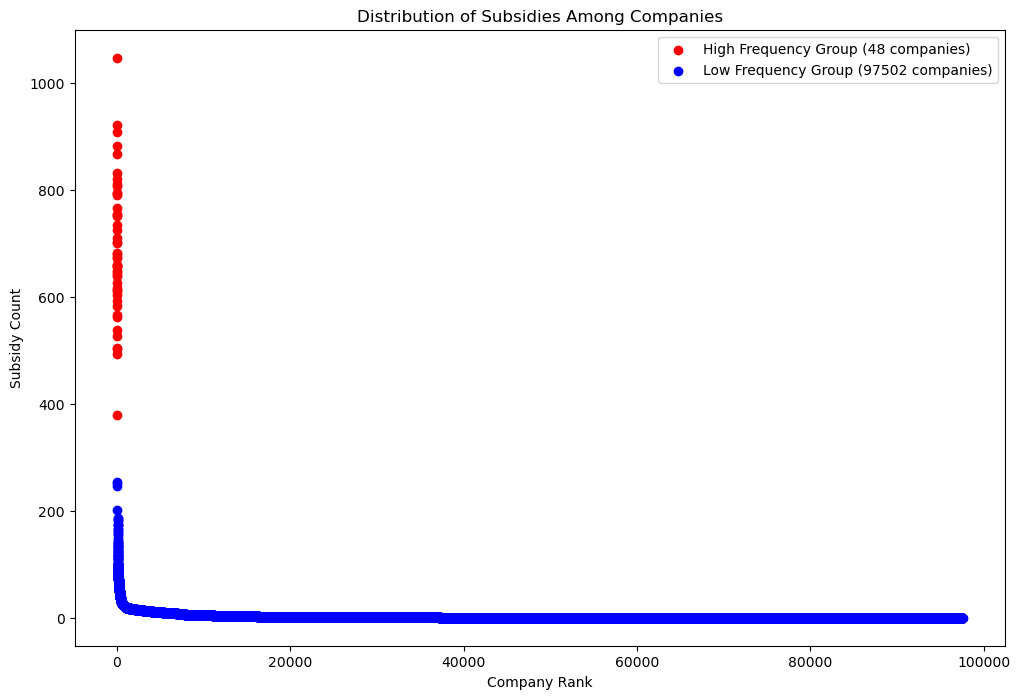

In [188]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# データ読み込み（実際の環境では既にDataFrameが読み込まれている）
# company_counts_df = pd.read_csv('company_counts-1.csv')

# K-meansでクラスタリング（2グループ）
X = company_counts_df['subsidy_count'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
company_counts_df['cluster'] = kmeans.fit_predict(X)

# クラスタ中心点を取得
centers = kmeans.cluster_centers_
# 高頻度グループと低頻度グループを特定（クラスタ中心値の大きさで判断）
high_cluster = np.argmax([c[0] for c in centers])
low_cluster = np.argmin([c[0] for c in centers])

# 高頻度グループと低頻度グループに分割
high_frequency_group_df = company_counts_df[company_counts_df['cluster'] == high_cluster]
low_frequency_group_df = company_counts_df[company_counts_df['cluster'] == low_cluster]

# 結果確認
print(f"高頻度グループ: {len(high_frequency_group_df)}社, 平均補助金数: {high_frequency_group_df['subsidy_count'].mean():.2f}")
print(f"低頻度グループ: {len(low_frequency_group_df)}社, 平均補助金数: {low_frequency_group_df['subsidy_count'].mean():.2f}")

# グループの特徴を視覚化
plt.figure(figsize=(12, 8))

plt.scatter(range(len(high_frequency_group_df)), 
            high_frequency_group_df['subsidy_count'], 
            c='red', 
            label=f'High Frequency Group ({len(high_frequency_group_df)} companies)')

plt.scatter(range(len(high_frequency_group_df), len(company_counts_df)), 
            low_frequency_group_df['subsidy_count'], 
            c='blue', 
            label=f'Low Frequency Group ({len(low_frequency_group_df)} companies)')

plt.xlabel('Company Rank')
plt.ylabel('Subsidy Count')
plt.title('Distribution of Subsidies Among Companies')
plt.legend()

plt.show()

